In [1]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

In [2]:
import os
import numpy as np
import pandas as pd
import pyranges as pr
import scanpy as sc
import seaborn as sns

from matplotlib import pyplot as plt
import tqdm
import glob
import polars as pl
import torch
from trackplot.plot import Plot


from torch.utils.data import DataLoader
from accelerate import Accelerator

from enformer_pytorch.data import GenomeIntervalDataset, str_to_one_hot
from tangermeme.plot import plot_logo

from scooby.modeling import Scooby
from scooby.data import onTheFlyExonMultiomePseudobulkDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_gene_slice_and_strand, get_pseudobulk_profile_pred, region_to_bin
from scooby.utils.transcriptome import Transcriptome
from scooby.utils.plotting import add_heatmap_to_axes, plot_tracks

In [3]:
data_path = '/s/project/QNA/scborzoi/submission_data/'

### Specify genome

In [4]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.gtf")
fasta_file = os.path.join(data_path, "scooby_training_data", "genome_human.fa")
bed_file = os.path.join(data_path, "scooby_training_data", "sequences.bed")

In [5]:
gtf = pr.read_gtf(gtf_file, duplicate_attr = True)

In [6]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'scooby_training_data', 'celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [7]:
cell_type_index['celltype_name'] = cell_type_index['celltype'].copy()
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog")
cell_type_index = cell_type_index.sort_values('celltype')

In [8]:
cell_type_index = cell_type_index.reset_index(drop=True)

In [9]:
context_length = 524288 
clip_soft=5

### Read in adata

In [10]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad')
)

In [11]:
ct_colors = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))

### Read in predicted SNPs

In [12]:
snp_preds = pd.read_pickle(os.path.join(data_path, "eQTL_preds", "susie_snps_preds_fixed.pickle")).iloc[:15900]

In [13]:
snp_preds_2 = pd.read_pickle(os.path.join(data_path, "eQTL_preds", "susie_snps_preds_fixed_16k.pickle"))

In [14]:
snp_preds = pd.concat([snp_preds, snp_preds_2])

In [15]:
snp_preds = snp_preds.dropna()

In [16]:
snp_preds = snp_preds.rename({'gene_name' : 'Gene', 'variant_hg38' : 'snp_id'}, axis = 1)

In [17]:
filter_ = snp_preds.groupby(['snp_id', 'Gene']).size().index[(snp_preds.groupby(['snp_id', 'Gene']).size() ==12).values]

In [18]:
snp_preds = snp_preds.set_index(['snp_id', 'Gene']).loc[filter_].reset_index()

In [19]:
# signed difference
def celltype_difference(df):
    # pseudobulk
    df['pred'] = df.apply((lambda x: np.array([np.log2(x['pred'][cellindex].sum() + 1) for cellindex in cell_type_index.cellindex])), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    return df

In [20]:
def all_difference(df):
    # pseudobulk
    df['pred'] = df.apply(lambda x: np.array(np.log2(x['pred'].sum() + 1) ), axis=1)
    df['pred_sum'] = df.apply(lambda x: np.array(x['pred'].sum() ), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    return df

In [21]:
ct_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(celltype_difference)

In [22]:
ct_differences = ct_differences['difference'].apply(lambda x: pd.Series(x, index=cell_type_index.celltype_name)).reset_index()

In [23]:
all_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(all_difference)

In [24]:
all_differences = all_differences['difference'].apply(lambda x: pd.Series(x, index=['all'])).reset_index()

## Whole heatmap, filter for sign concoordant and mean expr > 0.05 (a,b)

In [25]:
sign_concordant_all = all_differences.query("type == 'eSNP'").set_index(['snp_id', 'Gene'])[['all', 'type']].melt(id_vars='type', ignore_index=False).reset_index().pivot(columns='type', values='value', index=['variable', 'snp_id', 'Gene']).join(snp_preds.set_index(['snp_id', 'Gene']).query("type=='eSNP'").drop('pred', axis=1), on=['snp_id', 'Gene'])

sign_concordant_all = sign_concordant_all[(np.sign(sign_concordant_all['beta_posterior'].values) == np.sign(sign_concordant_all['eSNP'].values))]
sign_concordant_all[['beta_posterior', 'eSNP']]
#sign_concordant = sns_df[(np.sign(sns_df['beta_posterior'].values) == np.sign(sns_df['eSNP'].values))]
ct_differences = ct_differences.set_index(['snp_id', 'Gene']).query('type == "eSNP"').loc[sign_concordant_all.index.droplevel(0)].reset_index()



means = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).iloc[:,2:].T.abs().mean(axis=0)  
variances = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).iloc[:,2:].T.var(axis=0) 
quantiles = variances.loc[means[means > 0.05].index].quantile([.15, .85]).values

In [26]:
ct_differences = ct_differences.set_index(['snp_id','Gene'])[means > 0.05].reset_index()
var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
(variances > quantiles[1]) & (means > 0.05) ].index
non_var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
(variances < quantiles[0]) & (means > 0.05) ].index

/scratch/tmp/martensl/ipykernel_3571872/2252236172.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[
/scratch/tmp/martensl/ipykernel_3571872/2252236172.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_var_genes = ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene'])[


In [27]:
len(ct_differences)

370

In [28]:
ct_colors = pd.Series(adata.uns['l2_cell_type_colors'], 
                     index=adata.obs['l2_cell_type'].values.categories)

In [29]:
colors_equal = dict()
for lineage in adata.obs.l1_cell_type.unique():
    l2_cell_types = adata.obs.query("l1_cell_type == @lineage").l2_cell_type.unique().tolist()
    
    if " B" in l2_cell_types[0] or 'Early' in l2_cell_types[0] or 'Plasma' in l2_cell_types[0]:
        setter = '#023fa5'
    elif "T " in l2_cell_types[0] or 'NK' in l2_cell_types[0]:
        setter = '#c5dbc6'
    elif "Mono" in l2_cell_types[0]:
        setter = '#8e063b'
    elif 'Erythro' in l2_cell_types[0]:
        setter = '#8595e1'
    else:
        setter = '#808080'
    for l2 in l2_cell_types:
        colors_equal[l2] = setter


In [30]:
colors_equal['HSC'] = '#e4aeb8'
colors_equal['G/M prog'] = '#e4aeb8'
colors_equal['MK/E prog'] = '#e4aeb8'
colors_equal['ILC'] = '#c5dbc6'


In [31]:
gwas = pd.read_table(os.path.join(data_path, "eQTL_preds", "gwas_catalog.tsv"))

/scratch/tmp/martensl/ipykernel_3571872/59321694.py:1: DtypeWarning: Columns (9,11,12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas = pd.read_table(os.path.join(data_path, "eQTL_preds", "gwas_catalog.tsv"))


In [32]:
#! curl -o "$data_path"/eQTL_preds/GTEx_Analysis_v8_eQTL.tar https://storage.googleapis.com/adult-gtex/bulk-qtl/v8/single-tissue-cis-qtl/GTEx_Analysis_v8_eQTL.tar

In [33]:
#! tar -xf "$data_path"/eQTL_preds/GTEx_Analysis_v8_eQTL.tar -C "$data_path"/eQTL_preds/

In [34]:
rs_id_match = []
for path in tqdm.tqdm(glob.glob(os.path.join(data_path, 'eQTL_preds', "GTEx_Analysis_v8_eQTL/*.egenes.txt.gz"))):
    rs_id_match.append(pd.read_table(path)[['variant_id', 'rs_id_dbSNP151_GRCh38p7']])
rs_id_match = pd.concat(rs_id_match)

100%|██████████| 49/49 [00:05<00:00,  8.88it/s]


In [35]:
rs_id_match['snp_id'] = rs_id_match['variant_id'].str.replace("_b38", "")
rs_id_merge = ct_differences.merge(rs_id_match[['snp_id', 'rs_id_dbSNP151_GRCh38p7']].drop_duplicates(), on = 'snp_id', how = 'left')

In [36]:
gwas_mapped = rs_id_merge.set_index(['snp_id', 'Gene']).loc[var_genes].reset_index().merge(gwas[['SNPS', 'DISEASE/TRAIT', 'MAPPED_GENE']], left_on= ['rs_id_dbSNP151_GRCh38p7', 'Gene'], right_on=['SNPS','MAPPED_GENE'])[['Gene', 'rs_id_dbSNP151_GRCh38p7', 'DISEASE/TRAIT', 'MAPPED_GENE']]
highlight_genes = gwas_mapped.Gene.unique()

gwas_mapped = gwas_mapped.groupby(['Gene', 'rs_id_dbSNP151_GRCh38p7']).agg(list)

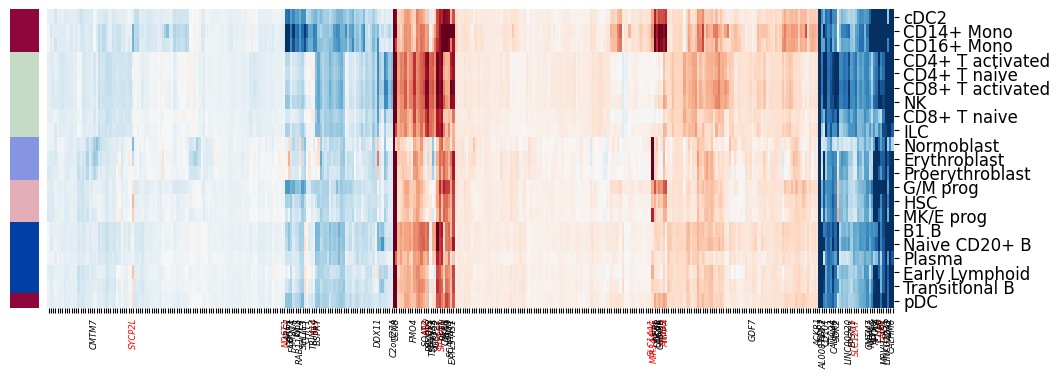

In [37]:
clustergrid = sns.clustermap(ct_differences.set_index(['snp_id','Gene']).reset_index(0).iloc[:,2:].T, 
            robust=True, 
            metric = "seuclidean", 
            method = 'ward', 
            yticklabels = 1,
            xticklabels = 1,  
            figsize=(12,6), 
            row_colors= [colors_equal[x] for x in ct_differences.set_index(['snp_id','Gene']).reset_index(0).iloc[:,2:].columns.tolist()],
            cmap = 'RdBu_r', 
            center=0, 
            row_cluster=True,
            col_cluster=True,
            vmin = -1, vmax = 1,
            dendrogram_ratio=(0.1, .3))
clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)
labels = clustergrid.ax_heatmap.get_xticklabels()
for lbl in labels:
    lbl.set_fontsize(6) 
    if lbl.get_text() in highlight_genes:# var_genes.get_level_values(1).values:
        lbl.set_color('red')
    elif lbl.get_text() in var_genes.get_level_values(1).values:
        lbl.set_color('black')
    else:
        lbl.set_visible(False)
    
    lbl.set_style('italic')
clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
row_order = clustergrid.dendrogram_row.reordered_ind
# plt.savefig('../figures/figures/Figure4/heatmap_all_concordant_colored_by_gwas.svg', dpi=300, bbox_inches ='tight')

In [38]:
row_colors = [colors_equal[x] for x in ct_differences.iloc[:,3:].iloc[:,row_order].columns.tolist()]

Text(644.0277777777778, 0.5, '')

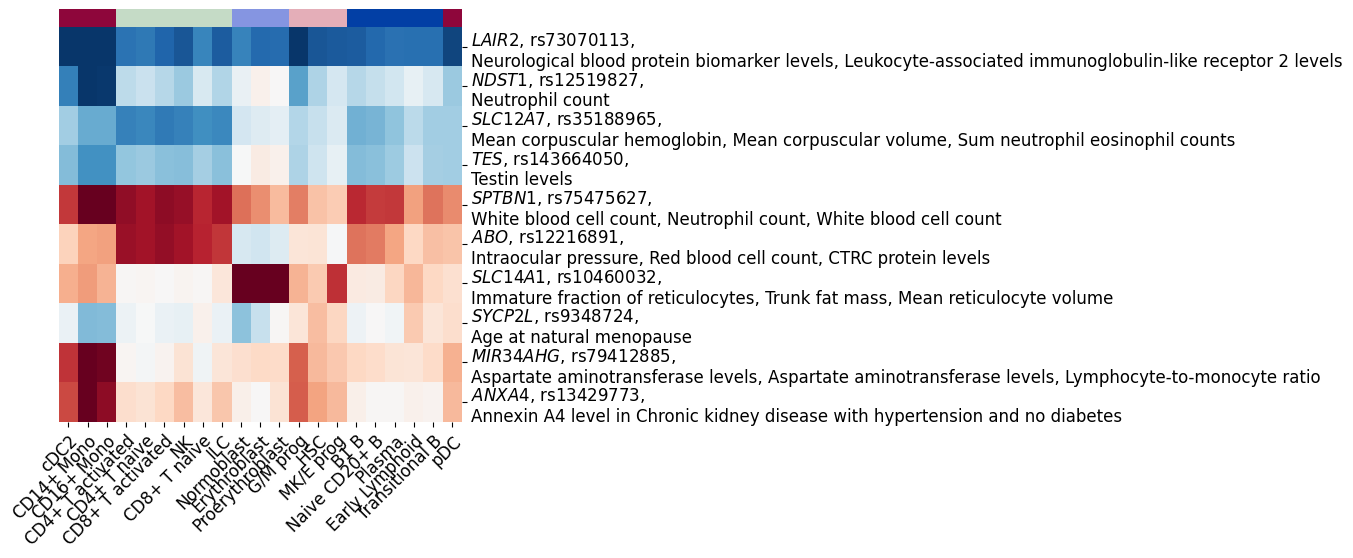

In [39]:
import math
clustergrid = sns.clustermap(ct_differences.query('type == "eSNP"').set_index(['snp_id','Gene']).loc[var_genes].reset_index(0).loc[highlight_genes].iloc[:,2:].iloc[:,row_order], 
               robust=True, 
               metric = "seuclidean", 
               method = 'ward', 
               yticklabels = 1,
               xticklabels = 1, 
               col_colors=row_colors,
               figsize=(6,8), 
               cmap = 'RdBu_r', col_cluster = False,
               center=0, 
               dendrogram_ratio=(0.1, .3))
clustergrid.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
clustergrid.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
clustergrid.ax_cbar.set_visible(False)
labels = clustergrid.ax_heatmap.get_yticklabels()
labels_new = []
rs_ids = []
for lbl in labels:
    lbl_text = lbl.get_text()
    rs_id = rs_id_merge.query("Gene == @lbl_text")['rs_id_dbSNP151_GRCh38p7'].iloc[0]
    if "SLC12A7" in lbl_text:
        terms = ", ".join(gwas_mapped.loc[lbl_text].iloc[0]['DISEASE/TRAIT'][3:3+3])
    else:
        terms = ", ".join(gwas_mapped.loc[lbl_text].iloc[0]['DISEASE/TRAIT'][-3:])
    if "Annexin" in terms:
        terms = terms.replace("(17164_15)", "")
    if type(rs_id) == float:
        rs_id = manual_merge[lbl_text]
        # print (lbl_text)
    rs_ids.append(rs_id)
    labels_new.append("$\it{" + lbl_text + "}$"+ f", {rs_id},\n{terms}")
clustergrid.ax_heatmap.set_yticklabels(labels_new)
labels = clustergrid.ax_heatmap.get_yticklabels()
clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_yticklabels())
clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
for lbl in labels:
    pass
    # lbl.set_style('italic')
    #lbl.set_ha("right")
    #lbl.set_rotation(20)

clustergrid.ax_heatmap.set_xlabel("")
clustergrid.ax_heatmap.set_ylabel("")
# plt.savefig('../figures/figures/Figure4/GWAS_only.png', dpi=300, bbox_inches ='tight')

## Profiles (c)

In [40]:
def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp = fix_rev_comp_multiome(flipped_version) 
    return (outputs + outputs_rev_comp)/2

In [41]:
genes_to_test = pd.concat([ct_differences.query('type == "eSNP"').set_index(["snp_id", "Gene"]).loc[non_var_genes].reset_index(),
                           ct_differences.query('type == "eSNP"').set_index(["snp_id", "Gene"]).loc[var_genes].reset_index()]
                         )

In [42]:
genes_to_test = genes_to_test[genes_to_test.Gene.isin( ["DCTN5", "TES"])] #

In [43]:
genes_to_test

celltype_name,snp_id,Gene,type,B1 B,CD14+ Mono,CD16+ Mono,CD4+ T activated,CD4+ T naive,CD8+ T activated,CD8+ T naive,...,ILC,MK/E prog,NK,Naive CD20+ B,Normoblast,Plasma,Proerythroblast,Transitional B,cDC2,pDC
12,chr16_23642022_C_T,DCTN5,eSNP,0.083043,0.089361,0.088050,0.078491,0.079047,0.078717,0.078400,...,0.075344,0.065959,0.078513,0.083420,0.054320,0.073566,0.056572,0.079107,0.082273,0.082659
46,chr7_116211123_G_A,TES,eSNP,-0.466523,-0.649831,-0.650397,-0.425851,-0.399438,-0.443410,-0.367176,...,-0.449190,-0.091629,-0.458902,-0.447667,-0.005217,-0.389551,0.049210,-0.364435,-0.464992,-0.373669


In [21]:
base_path = os.path.join(data_path, 'scooby_training_data', 'pseudobulks')

In [22]:
# read in ATAC peaks
atac_peaks = pr.PyRanges(pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'atac_peaks.csv'), index_col=0))

In [23]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

csb = Scooby.from_pretrained(
    'johahi/neurips-scooby',
    cell_emb_dim=14,
    embedding_dim=1920,
    n_tracks=3,
    return_center_bins_only=True,
    disable_cache=False,
    use_transform_borzoi_emb=True,
)

csb = accelerator.prepare(csb)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [24]:
transcriptome = Transcriptome(gtf_file)

In [31]:
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data',  'embedding_no_val_genes_new.pq'))
csb.eval()
cell_indices  = []

#for _, row in tqdm.tqdm(cell_type_index.query("(celltype == 'CD14+_Mono') | (celltype == 'Erythroblast') ").iterrows(),disable = True):
for _, row in tqdm.tqdm(cell_type_index.iterrows(),disable = True):
    if row['celltype_name'] in ['Erythroblast', 'CD14+ Mono']: 
        print(row['celltype_name'])
        cell_indices.append(
            torch.from_numpy(
                np.vstack(
                    embedding.iloc[row['cellindex']]['embedding'].values # gets embeddings of all cells of the cell type
                    )
                ).unsqueeze(0)
            ) # prep cell_embeddings

# get conv weights and biases for all cells sorted by cell type in a list
cell_emb_conv_weights_and_biases =[]
for cell_emb_idx in tqdm.tqdm(cell_indices, disable = True):
    with torch.no_grad():
        cell_emb_idx = cell_emb_idx.cuda()
        conv_weights, conv_biases = csb.forward_cell_embs_only(cell_emb_idx)
        cell_emb_conv_weights_and_biases.append((conv_weights, conv_biases))


Erythroblast


['DCTN5', 'chr16_23642022_C_T']
C T
244697


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
2024-11-05 15:13:27.633 | INFO     | trackplot.plot:__init__:210 - Create trackplot version: 0.5.1
2024-11-05 15:13:27.634 | INFO     | trackplot.plot:set_region:266 - set region to chr16:23631852-23687052:+


DCTN5


2024-11-05 15:13:45.993 | INFO     | trackplot.plot:set_annotation:435 - set annotation file to /s/project/QNA/scborzoi/submission_data/gencode.v32.annotation.sorted.gtf.gz


['TES', 'chr7_116211123_G_A']
G A
238622


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
2024-11-05 15:13:47.406 | INFO     | trackplot.plot:__init__:210 - Create trackplot version: 0.5.1
2024-11-05 15:13:47.408 | INFO     | trackplot.plot:set_region:266 - set region to chr7:116200916-116268340:+


TES


2024-11-05 15:14:04.943 | INFO     | trackplot.plot:set_annotation:435 - set annotation file to /s/project/QNA/scborzoi/submission_data/gencode.v32.annotation.sorted.gtf.gz


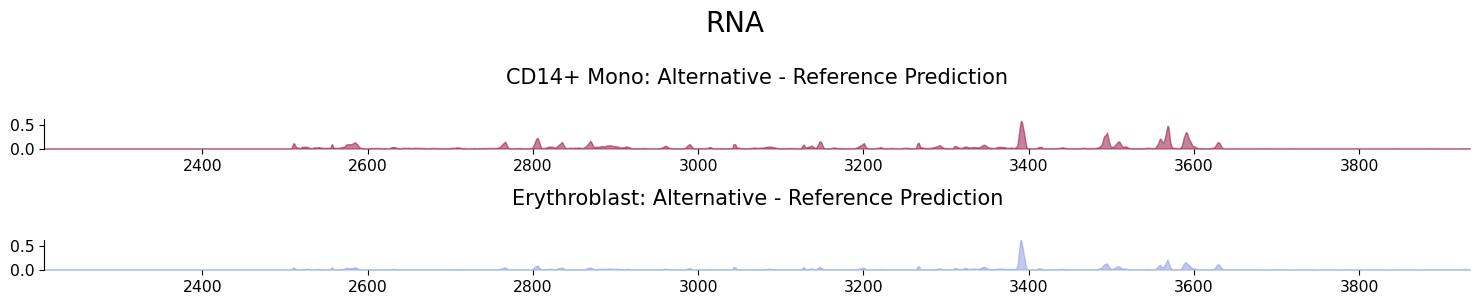

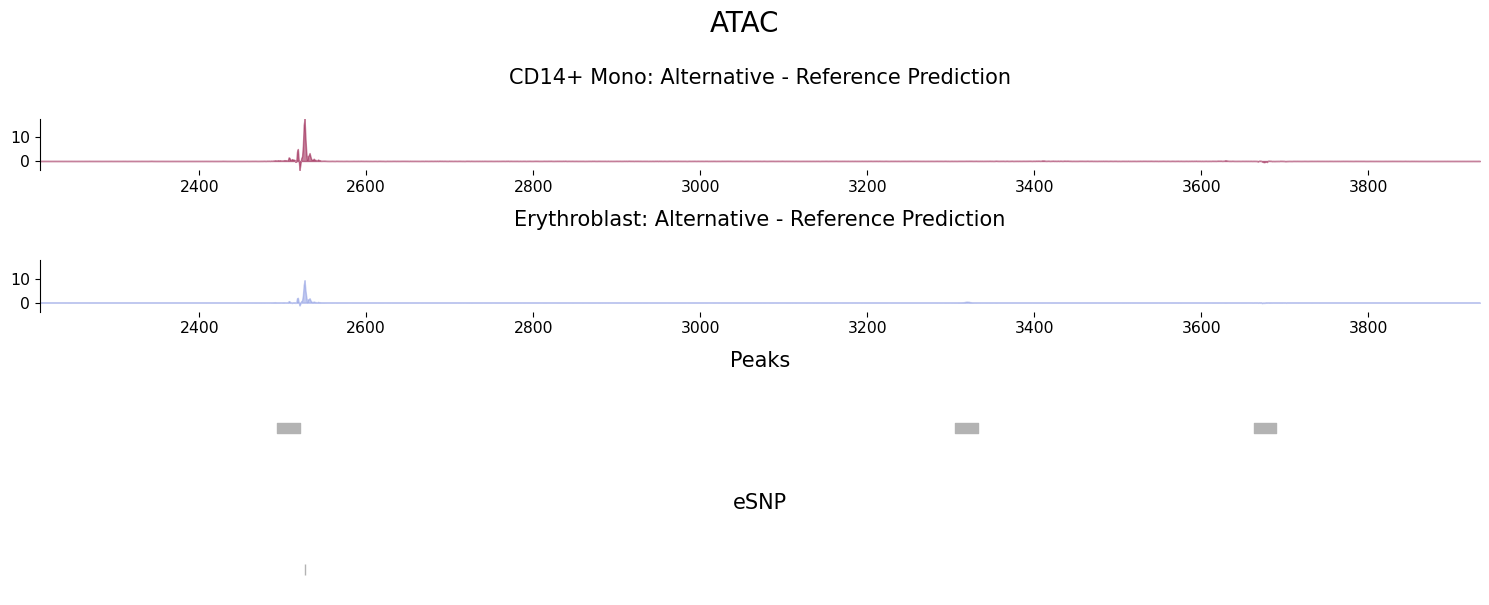

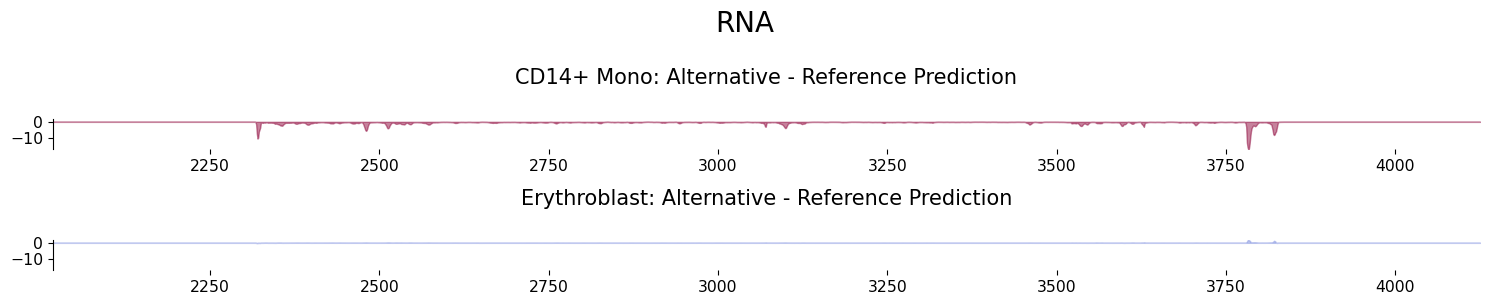

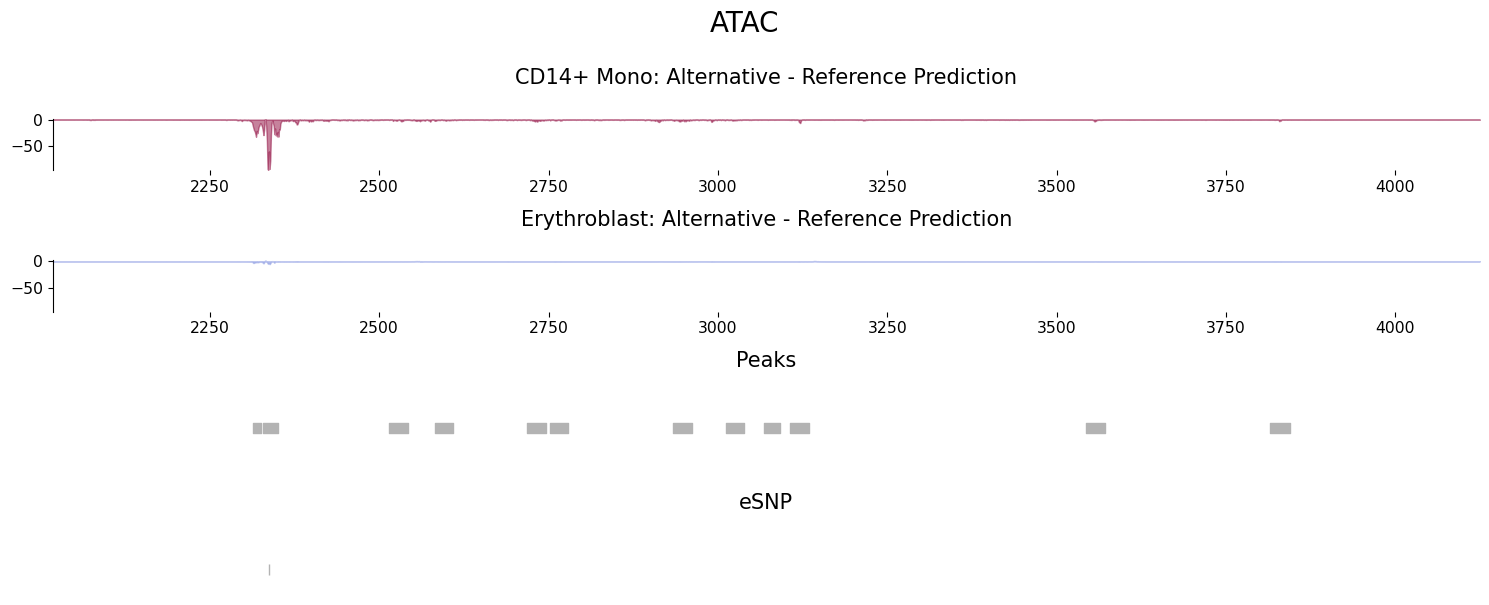

In [49]:

for i_gene, (_, row) in enumerate(genes_to_test.iterrows()):

    print([row['Gene'], row['snp_id']])

    gene, rsid = row['Gene'], row['snp_id']
    row_to_process = snp_preds.query("type == 'ref'").query('(snp_id == @rsid) & (Gene == @gene)')
    hg38_pos = int(row_to_process['Start'].item())
    ref = row_to_process['nuc'].item()
    alt = snp_preds.query("type == 'eSNP'").query('(snp_id == @rsid) & (Gene == @gene)')['nuc'].item()
    print(ref, alt)
    
    genes = pd.Series([
        gene
    ])
    
    filter_val = lambda df: df.filter(pl.col('column_4').is_in(genes))#
    #filter_val = lambda df: df.filter(True)
    val_ds = GenomeIntervalDataset(
        bed_file = os.path.join(data_path, 'scooby_training_data', 'train_val_test_gene_sequences.csv'),
        fasta_file = fasta_file,
        filter_df_fn = filter_val,
        return_seq_indices = False,
        shift_augs = (0,0),
        rc_aug = False,
        return_augs = True,
        context_length = context_length,
        chr_bed_to_fasta_map = {}
    )
    
    val_dataset = onTheFlyExonMultiomePseudobulkDataset(
        cell_types = ['CD14+_Mono', 'Erythroblast'],
        ds = val_ds,
        base_path = base_path,
        clip_soft = 5,
    )
    
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
    csb, val_loader = accelerator.prepare(csb, val_loader)
    
    
    all_outputs_rna, all_outputs_atac, all_outputs_rna_alt, all_outputs_atac_alt, all_targets_rna, all_targets_atac = [], [], [], [],[], []
    
    genotype_map = {0:"alt",  2:"ref"}
    
    diff_target, diff_predicted, snps_tested = [], [], []
    csb.eval()
    
    
    # Test how our model predicts SNP effects
    
    ### Get outputs for all cells for that region
    
    alt = str_to_one_hot(alt).cuda() 
    ref = str_to_one_hot(ref).cuda()

    start = val_ds.df['column_2'].item() - ((context_length - (6144*32))//2)
    
    snp_idx = hg38_pos - start - 1
    print(snp_idx)
    # iterate over all val gene sequences
    for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):   
        gene_slice, strand = get_gene_slice_and_strand(
            transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
        )
        bs = x[0].shape[0]
        seqs = x[0].cuda().permute(0,2,1)
        seqs_alt = seqs.clone()
        assert torch.allclose(seqs_alt[:, :, snp_idx], ref)
        seqs_alt[:, :, snp_idx] = alt 
        assert torch.allclose(seqs_alt[:, :, snp_idx], alt)
        stacked_outputs_rna, stacked_outputs_atac, stacked_counts_outputs_rna = [], [], []
    
        # go over embeddings for all cells of a cell type, sum the unsquashed predictions
        outputs = get_pseudobulk_profile_pred(csb, seqs, cell_emb_conv_weights_and_biases, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1)
        all_outputs_rna.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu()) 
        all_outputs_atac.append(outputs[2].detach().clone().cpu()) 
    
        # go over embeddings for all cells of a cell type, sum the unsquashed predictions
        outputs = get_pseudobulk_profile_pred(csb, seqs_alt, cell_emb_conv_weights_and_biases, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1)
        all_outputs_rna_alt.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu()) 
        all_outputs_atac_alt.append(outputs[2].detach().clone().cpu()) 
        
        targets = x[2].float().cuda()
        # get RNA:
        targets_rna = targets[:,:,torch.tensor([1,1,0]).repeat(targets.shape[2]//3).bool()]
        targets_rna = targets_rna.float().detach()
    
        num_pos = targets_rna.shape[-1]
        # get ATAC:
        targets_atac = targets[:,:,torch.tensor([0,0,1]).repeat(targets.shape[2]//3).bool()]
        targets_atac = targets_atac.float().detach()
        if strand == '+':
            all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, :num_pos:2], clip_soft=5).detach().clone().cpu().T)
        elif strand == '-':
            all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, 1:num_pos:2], clip_soft=5).detach().clone().cpu().T)
    
        all_targets_atac.append(targets_atac[0].detach().clone().cpu().T)


    all_outputs_rna, all_outputs_atac, all_outputs_rna_alt, all_outputs_atac_alt = torch.stack(all_outputs_rna, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac, axis=0).clone().numpy(force=True) , torch.stack(all_outputs_rna_alt, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac_alt, axis=0).clone().numpy(force=True)
    all_targets_rna, all_targets_atac = torch.stack(all_targets_rna, axis=0).clone().numpy(force=True), torch.stack(all_targets_atac, axis=0).clone().numpy(force=True)

    # all_outputs_atac_alt = all_outputs_atac_alt * 20 #np.abs(all_outputs_atac_alt * 20 - all_outputs_atac)
    all_outputs_atac_alt = all_outputs_atac_alt  - all_outputs_atac
    
    # all_outputs_rna_alt = all_outputs_rna_alt #
    all_outputs_rna_alt = all_outputs_rna_alt - all_outputs_rna
    
    size=15
    params = {'legend.fontsize': 'large',
              'figure.figsize': (10,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size*0.75,
              'ytick.labelsize': size*0.75,
              'axes.titlepad': 25}
    plt.rcParams.update(params)
    
    print(val_dataset.genome_ds.df[i, 'column_4'])
    gene = val_dataset.genome_ds.df[i, 'column_4']
    
    # Get gene range
    gene_slice, strand = get_gene_slice_and_strand(
            transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
        )
    
    
    # Get peaks
    region = val_dataset.genome_ds.df[i].to_pandas()
    region.columns = ['Chromosome', 'Start', 'End', 'Gene Name', 'Strand']
    region = pr.PyRanges(region)
    region_peaks = atac_peaks.overlap(region).df
    region_peaks = region_to_bin(region_peaks.Start, region_peaks.End, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )
    
    # Get snp
    region_snp = region_to_bin(row_to_process['Start'], row_to_process['Start']+1, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )
    
    # Get color map
    color_map = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))

    
    loffset=300
    roffset=300
    
    interval = (gene_slice.min()-loffset, gene_slice.max()+roffset)
    
    #ylim atac
    ylim_atac_out_alt = (all_outputs_atac_alt[:, :, interval[0]: interval[1]].min(), all_outputs_atac_alt[:, :, interval[0]: interval[1]].max())
    
    #ylim rna
    ylim_rna_out_alt = (all_outputs_rna_alt[:, :, interval[0]: interval[1]].min(), all_outputs_rna_alt[:, :, interval[0]: interval[1]].max())
   
    tracks_outputs_rna_alt = []
    tracks_outputs_atac_alt = []
    for idx, celltype in enumerate(['CD14+ Mono', 'Erythroblast']):
        cell_type = pd.Series([celltype])

        tracks_outputs_rna_alt.extend( list(
            zip(
                cell_type + ': Alternative - Reference Prediction', 
                all_outputs_rna_alt[0, [idx]]  ,
                np.repeat('coverage', 1),
                [ylim_rna_out_alt]
            )))
        
        tracks_outputs_atac_alt.extend(list(zip(
            cell_type + ': Alternative - Reference Prediction', 
            all_outputs_atac_alt[0, [idx]], 
            np.repeat('coverage', 1),
            [ylim_atac_out_alt]
        )))
        
    plot = Plot()
    plot.set_region( region.df["Chromosome"].item(), start= (region.df['Start'] + interval[0] * 32).item(), end= (region.df['Start'] + interval[1] * 32).item(), strand =strand)
    plot.set_annotation(
        os.path.join(data_path, 'gencode.v32.annotation.sorted.gtf.gz'),                                             # path to gtf file
        add_domain=False,                                                                # whether add domain information into annotation track
        show_gene=False,                                                                 # show gene id
        transcripts = sorted(gtf.df[gtf.df.gene_name.isin([gene]) & (gtf.df.Feature == 'transcript') &(gtf.df.tag.str.contains('CCDS'))]['transcript_name'].values.tolist()),
        #color="pink",                                                                   # the color of exons
    )

    # resort to RNa, ATAC
    tracks_rna = tracks_outputs_rna_alt #
    tracks_atac = tracks_outputs_atac_alt
    tracks =  tracks_rna  
    rna = plot_tracks(
        tracks=tracks_rna, 
        interval=interval, 
        color_map=color_map, 
        fig_title="RNA",
        height=1.5,
        #save_name="EIFA1_RNA.svg",
        #annotation_plot = plot,
        annotation_scale=1.2
    )
    # rna[0].savefig(f'../figures/figures/Figure4/{gene}_RNA.png', bbox_inches='tight', dpi=300)
    
    tracks = tracks_atac + [('Peaks', region_peaks, 'bed', None)] + [('eSNP', region_snp, 'bed', None)]
    atac = plot_tracks(
        tracks=tracks, 
        interval=interval, 
        color_map=color_map, 
        fig_title="ATAC",
        height=1.5,
        #save_name="EIFA1_ATAC.svg",
)
    # atac[0].savefig(f'../figures/figures/Figure4/{gene}_ATAC.png', bbox_inches='tight', dpi=300)

## Plot gradient (c)

In [27]:
def plot_sequence_logo(ax, data, title):
    plot_logo(data, ax=ax)
    ax.set_ylim(ax_lims)
    ax.set_title(title)
    #ax.set_ylabel("Attribution")
    ax.set_xticks([])
    ax.grid(False)

In [28]:
def predict_w_grads(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    assert bs == 1
    with torch.autocast("cuda"):
        outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
        if bins_to_predict is not None:
            outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
        else:
            outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp = fix_rev_comp_multiome(flipped_version)
    return (outputs + outputs_rev_comp)/2

In [29]:
def compute_expression(seqs):
    seqs_rev_comp =  torch.flip(seqs.permute(0,2,1), (-1, -2)).permute(0,2,1)
    stacked_outputs = []

    # go over embeddings for all cells of a cell type, sum the unsquashed predictions
    for i, (conv_weight, conv_bias) in enumerate(temp_cell_emb_conv_weights_and_biases):
        # get predictions for all cells of one cell type
        outputs = predict_w_grads(csb, seqs, seqs_rev_comp, conv_weight, conv_bias, bins_to_predict=temp_gene_slice) 
        # get RNA:
        if strand == '+':
            outputs = outputs[:,:,torch.tensor([1,0,0]).repeat(outputs.shape[2]//3).bool()]
            stacked_outputs.append(torch.log((undo_squashed_scale(outputs[0, :,:].float(), clip_soft=5) ).sum() +1))
        elif strand == '-':
            outputs = outputs[:,:,torch.tensor([0,1,0]).repeat(outputs.shape[2]//3).bool()]
            stacked_outputs.append(torch.log((undo_squashed_scale(outputs[0, :,:].float(), clip_soft=5) ).sum()+1))
        # sum exons on positive/negative strand for all cells
    return tuple(stacked_outputs)

['DCTN5', 'chr16_23642022_C_T']
C T


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0., 1., 0., 0.]], device='cuda:0')



  0%|          | 0/1 [00:00<?, ?it/s]
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/scratch/tmp/martensl/ipykernel_3596407/1409771870.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ax_lims)
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/scratch/tmp/martensl/ipykernel_3596407/1409771870.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ax_lims)


['TES', 'chr7_116211123_G_A']
G A


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0., 0., 1., 0.]], device='cuda:0')



  0%|          | 0/1 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 44.34 GiB of which 740.19 MiB is free. Including non-PyTorch memory, this process has 43.61 GiB memory in use. Of the allocated memory 42.97 GiB is allocated by PyTorch, and 321.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

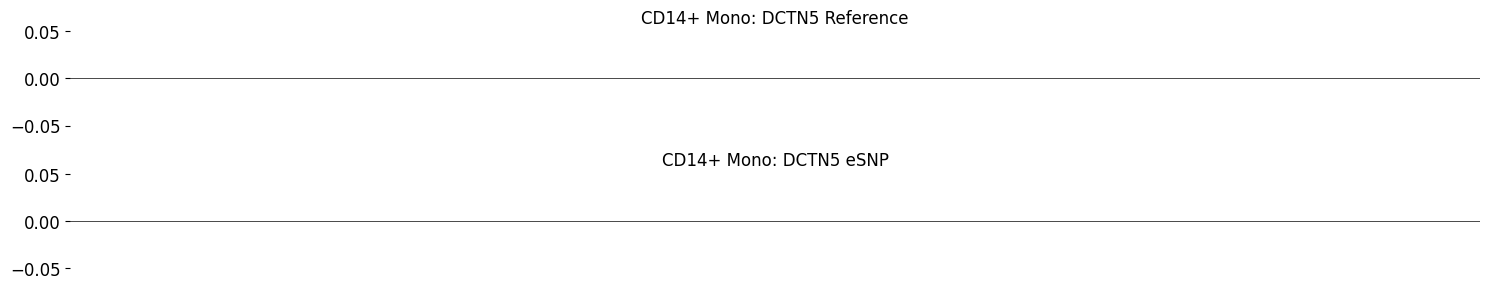

In [35]:
for i, row in genes_to_test.iterrows():
    print([row['Gene'], row['snp_id']])

    gene, rsid = row['Gene'], row['snp_id']
    row_to_process = snp_preds.query("type == 'ref'").query('(snp_id == @rsid) & (Gene == @gene)')
    hg38_pos = int(row_to_process['Start'].item())
    ref = row_to_process['nuc'].item()
    alt = snp_preds.query("type == 'eSNP'").query('(snp_id == @rsid) & (Gene == @gene)')['nuc'].item()
    print(ref, alt)
    
    genes = pd.Series([
        gene
    ])
    
    filter_val = lambda df: df.filter(pl.col('column_4').is_in(genes))#
    #filter_val = lambda df: df.filter(True)
    val_ds = GenomeIntervalDataset(
        bed_file = os.path.join(data_path,'scooby_training_data', 'train_val_test_gene_sequences.csv'),
        fasta_file = fasta_file,
        filter_df_fn = filter_val,
        return_seq_indices = False,
        shift_augs = (0,0),
        rc_aug = False,
        return_augs = True,
        context_length = context_length,
        chr_bed_to_fasta_map = {}
    )
    
    val_dataset = onTheFlyExonMultiomePseudobulkDataset(
        cell_types = cell_type_index['celltype'],
        ds = val_ds, 
        base_path = base_path,
        seqlevelstyle="UCSC",
        clip_soft=clip_soft,
    )
    
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
    csb, val_loader = accelerator.prepare(csb, val_loader)
    
    genotype_map = {0:"alt",  2:"ref"}
    
    diff_target, diff_predicted, snps_tested = [], [], []
    csb.eval()
    
    
    # Test how our model predicts SNP effects
    
    ### Get outputs for all cells for that region
    
    alt = str_to_one_hot(alt).cuda() 
    ref = str_to_one_hot(ref).cuda()
    
    start = val_ds.df['column_2'].item() - ((context_length - (6144*32))//2)
    
    snp_idx = hg38_pos - start - 1
    
    counts_outputs_rna, counts_outputs_rna_alt = [], []
    
    # iterate over all val gene sequences
    for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):   
        gene_slice, strand = get_gene_slice_and_strand(transcriptome,     val_dataset.genome_ds.df[i, 'column_4'],     val_dataset.genome_ds.df[i, 'column_2'], span=True)
        
        bs = x[0].shape[0]
        seqs = x[0].cuda().permute(0,2,1)
    
        seqs_alt = seqs.clone()
        print(seqs_alt[:, :, snp_idx])
        assert torch.allclose(seqs_alt[:, :, snp_idx], ref)
        seqs_alt[:, :, snp_idx] = alt 
        assert torch.allclose(seqs_alt[:, :, snp_idx], alt)
       
        temp_grads_ref, temp_grads_alt = [], []
        temp_gene_slice = gene_slice
        for i in tqdm.tqdm(range(0, len(cell_emb_conv_weights_and_biases), 1)):
            temp_cell_emb_conv_weights_and_biases = cell_emb_conv_weights_and_biases[i: i+1]
            inputs_ref=seqs 
            grads_ref = torch.autograd.functional.jacobian(compute_expression, inputs_ref)
            test = compute_expression(inputs_ref)
            temp_grads_ref.extend([g.half().detach().cpu() for g in grads_ref])

            inputs_alt=seqs_alt
            grads_alt = torch.autograd.functional.jacobian(compute_expression, inputs_alt)
            temp_grads_alt.extend([g.half().detach().cpu() for g in grads_alt])
        grads_ref = torch.stack(temp_grads_ref).squeeze()
        grads_alt = torch.stack(temp_grads_alt).squeeze()
        break
    
    if grads_ref.shape[0] == 4:
        grads_ref=grads_ref.unsqueeze(0)
        grads_alt=grads_alt.unsqueeze(0)
    inputxgrad_ref = (grads_ref * seqs.cpu())
    inputxgrad_alt = (grads_alt * seqs_alt.cpu())


    length=60
    ax_lims = min((inputxgrad_ref[:, :, snp_idx-length: snp_idx+length]).min(), (inputxgrad_alt[:, :, snp_idx-length: snp_idx+length]).min()).item(), max((inputxgrad_ref[:, :, snp_idx-length: snp_idx+length]).max(), (inputxgrad_alt[:, :, snp_idx-length: snp_idx+length]).max()).item()
    for logo_idx in range(inputxgrad_ref.shape[0]):
        ct = ["CD14+ Mono", "Erythroblast"][logo_idx]

        X_attr_ref = (torch.pow(torch.Tensor([2]),grads_ref[logo_idx, :, snp_idx-5: snp_idx+5])  * 0.25) 
    
        X_attr_ref /= X_attr_ref.sum(axis=0)
        X_attr_ref = X_attr_ref.T
        X_attr_alt = (torch.pow(torch.Tensor([2]),grads_alt[logo_idx, :, snp_idx-5: snp_idx+5])  * 0.25) #grads_alt[i, :, (snp_idx-context):(snp_idx+context)].abs() * seqs_alt[0]
        X_attr_alt /= X_attr_alt.sum(axis=0)
        X_attr_alt = X_attr_alt.T
    
        fig, axes = plt.subplots(2, figsize=(15, 3))
        plot_sequence_logo(axes[0], inputxgrad_ref[logo_idx, :, snp_idx-length: snp_idx+length], f"{ct}: {gene} Reference")
        plot_sequence_logo(axes[1], inputxgrad_alt[logo_idx, :, snp_idx-length: snp_idx+length], f"{ct}: {gene} eSNP") 
        plt.tight_layout()  # Adjusts subplot spacing
        # fig.savefig(f'../figures/figures/Figure4/{gene}_{ct}.png', dpi=300, bbox_inches='tight')

## Plot prediction on UMAP (d,e)

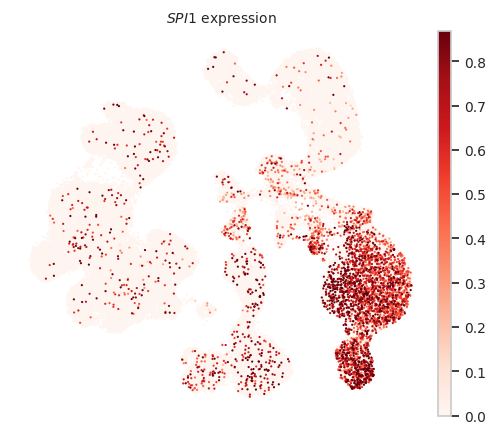

In [935]:
fig, ax = plt.subplots(figsize=(6,5))
sc.pl.umap(adata, color = f'SPI1', frameon = False, cmap = 'Reds', show = False, vmax = 'p99',  ax = ax, s = 10)
ax.set_title("$\it{SPI1}$ expression")#, font_size = 12)
# fig.savefig("../figures/figures/Figure4/SPI1_expression.png", dpi=300, bbox_inches ='tight')

In [444]:
adata.obs['TES effect'] = (np.log2(snp_preds.query('Gene == "TES" and type == "eSNP"').iloc[0]['pred']) - np.log2(snp_preds.query('Gene == "TES" and type == "ref"').iloc[0]['pred']) )#.shape
#adata.obs['TES effect'] = 

<Axes: title={'center': 'TES effect'}, xlabel='UMAP1', ylabel='UMAP2'>

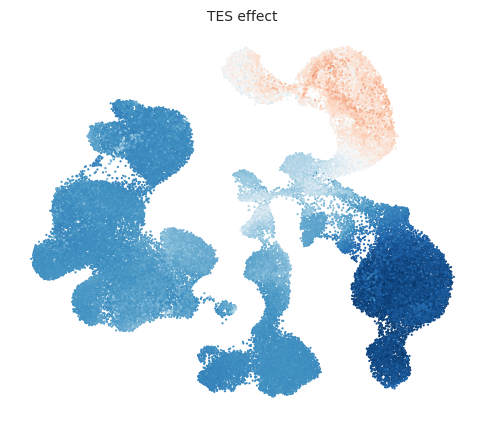

In [486]:
fig, ax = plt.subplots(figsize=(6,5))
sc.pl.umap(adata, color = 'TES effect', vcenter = 0,  cmap = 'RdBu_r', frameon = False, show = False, ax = ax, vmax = - np.quantile(adata.obs['TES effect'],0.01), vmin = np.quantile(adata.obs['TES effect'],0.01), colorbar_loc = None, s = 10)

In [487]:
ax.set_title("Variant effect on $\it{TES}$ expression")#, font_size = 12)
# fig.savefig("../figures/figures/Figure4/TES_effect.png", dpi=300, bbox_inches ='tight')